# Getting Started

In [1]:
# # Upload Kaggle json

# !pip install -q kaggle
# !pip install -q kaggle-cli
# !mkdir -p ~/.kaggle
# !cp "/content/drive/My Drive/Kaggle/kaggle.json" ~/.kaggle/ # Mount GDrive
# !cat ~/.kaggle/kaggle.json 
# !chmod 600 ~/.kaggle/kaggle.json
# !kaggle competitions download -c fake-news -p dataset
# !unzip /content/dataset/train.csv.zip
# !unzip /content/dataset/test.csv.zip

In [2]:
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
from matplotlib import rcParams
plt.rcParams['figure.figsize'] = [10,10]
import seaborn as sns
sns.set_theme(style="darkgrid")
from wordcloud import WordCloud

import nltk
from nltk import sent_tokenize
# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords = nltk.corpus.stopwords.words('english')
from nltk.tokenize import word_tokenize
import contractions
import string

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding

In [3]:
# train_df = pd.read_csv('/content/train.csv', header=0)
# test_df = pd.read_csv('/content/test.csv', header=0)

train_df = pd.read_csv('fake-news/train.csv', header=0)
test_df = pd.read_csv('fake-news/test.csv', header=0)

In [4]:
train_df = train_df.fillna(' ')
test_df = test_df.fillna(' ')

train_df['text'] = train_df['text'].str.strip()
test_df['text'] = test_df['text'].str.strip()

train_df['raw_text_length'] = train_df['text'].apply(lambda x: len(x))
print(len(train_df[train_df['raw_text_length']==0]))

116


In [5]:
train_df = train_df[train_df['raw_text_length'] > 0]
train_df.shape

(20684, 6)

In [6]:
def preprocess_text(x):
    try:
        cleaned_text = re.sub(r'[^a-zA-Z\d\s\']+', '', x)
        word_list = []
        for each_word in cleaned_text.split(' '):
            word_list.append(contractions.fix(each_word).lower())
    except:
        print(x)
    return " ".join(word_list)

In [7]:
text_cols = ['text', 'title', 'author']

In [8]:
%%time
for col in text_cols:
    print("Processing column: {}".format(col))
    print("Processing train data... ")
    train_df[col] = train_df[col].apply(lambda x: preprocess_text(x))
    print("Processing test data... ")
    test_df[col] = test_df[col].apply(lambda x: preprocess_text(x))

Processing column: text
Processing train data... 
Processing test data... 
Processing column: title
Processing train data... 
Processing test data... 
Processing column: author
Processing train data... 
Processing test data... 
Wall time: 2min 12s


In [9]:
%%time
for col in text_cols:
    print("Processing column: {}".format(col))
    print("Processing train data... ")
    train_df[col] = train_df[col].apply(word_tokenize)
    print("Processing test data... ")
    test_df[col] = test_df[col].apply(word_tokenize)

Processing column: text
Processing train data... 
Processing test data... 
Processing column: title
Processing train data... 
Processing test data... 
Processing column: author
Processing train data... 
Processing test data... 
Wall time: 2min 20s


In [10]:
%%time
for col in text_cols:
  print("Processing column: {}".format(col))
  print("Processing train data... ")
  train_df[col] = train_df[col].apply(lambda x: [each_word for each_word in x if each_word not in stopwords])
  print("Processing test data... ")
  test_df[col] = test_df[col].apply(lambda x: [each_word for each_word in x if each_word not in stopwords])

Processing column: text
Processing train data... 
Processing test data... 
Processing column: title
Processing train data... 
Processing test data... 
Processing column: author
Processing train data... 
Processing test data... 
Wall time: 1min 3s


In [11]:
print("Processing train data... ")
train_df['all_info'] = train_df['text'] + train_df['title'] + train_df['author'] 
train_df['all_info'] = train_df['all_info'].apply(lambda x: " ".join(x))
print("Processing test data... ")
test_df['all_info'] = test_df['text'] + test_df['title'] + test_df['author'] 
test_df['all_info'] = test_df['all_info'].apply(lambda x: " ".join(x))

Processing train data... 
Processing test data... 


In [12]:
all_text_train = train_df["all_info"].astype(str).tolist()
all_text_test = test_df["all_info"].astype(str).tolist()

In [13]:
target = train_df['label'].values

In [14]:
tokenizer = Tokenizer(oov_token = "<OOV>", num_words=6000)
tokenizer.fit_on_texts(all_text_train)
word_index = tokenizer.word_index
len(word_index)

189820

In [15]:
sequences_train = tokenizer.texts_to_sequences(all_text_train)
padded_train = pad_sequences(sequences_train, padding = 'post', maxlen=6000)

sequences_test = tokenizer.texts_to_sequences(all_text_test)
padded_test = pad_sequences(sequences_test, padding = 'post', maxlen=6000)

In [ ]:
def get_model():
  model=Sequential()
  model.add(Embedding(6000, 300 ,input_length=6000))
  model.add(Dropout(0.3))
  model.add(LSTM(200))
  model.add(Dropout(0.3))
  model.add(Dense(64,activation='relu'))
  model.add(Dropout(0.3))
  model.add(Dense(1,activation='sigmoid'))
  return model

model = get_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 6000, 300)         1800000   
_________________________________________________________________
dropout_6 (Dropout)          (None, 6000, 300)         0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 200)               400800    
_________________________________________________________________
dropout_7 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                12864     
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(padded_train, target, test_size=0.2)

In [ ]:
callbacks=[
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=15, 
                                  verbose=1, mode="min", restore_best_weights=True),
    keras.callbacks.ModelCheckpoint(filepath="best_model.hdf5", verbose=1, save_best_only=True)
]

In [ ]:
model = get_model()
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
%%time
history = model.fit(X_train, 
                    y_train, 
                    epochs=20,
                    batch_size=64, 
                    validation_data=(X_test, y_test), 
                    callbacks=callbacks)

Epoch 1/20
259/259 [==============================] - 197s 754ms/step - loss: 0.6956 - accuracy: 0.4890 - val_loss: 0.6936 - val_accuracy: 0.4977

Epoch 00001: val_loss improved from inf to 0.69358, saving model to best_model.hdf5
Epoch 2/20
259/259 [==============================] - 198s 764ms/step - loss: 0.6936 - accuracy: 0.5102 - val_loss: 0.6937 - val_accuracy: 0.4977

Epoch 00002: val_loss did not improve from 0.69358
Epoch 3/20
259/259 [==============================] - 198s 766ms/step - loss: 0.6938 - accuracy: 0.4934 - val_loss: 0.6935 - val_accuracy: 0.5028

Epoch 00003: val_loss improved from 0.69358 to 0.69353, saving model to best_model.hdf5
Epoch 4/20
259/259 [==============================] - 198s 766ms/step - loss: 0.6935 - accuracy: 0.4985 - val_loss: 0.6931 - val_accuracy: 0.5028

Epoch 00004: val_loss improved from 0.69353 to 0.69313, saving model to best_model.hdf5
Epoch 5/20
259/259 [==============================] - 198s 766ms/step - loss: 0.6933 - accuracy: 0.49

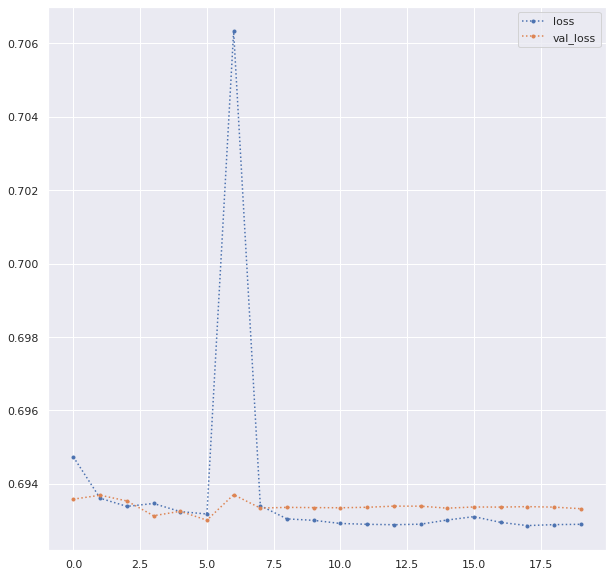

In [ ]:
metric_toplot = "loss"
plt.plot(history.epoch, history.history[metric_toplot], ".:", label="loss")
plt.plot(history.epoch, history.history["val_"+metric_toplot], ".:", label="val_loss")
plt.legend()
plt.show()

In [ ]:
model = keras.models.load_model('best_model.hdf5')

In [ ]:
y_pred = model.predict_classes(X_test)

In [ ]:
y_test.shape, y_pred.shape

((4137,), (4137, 1))

In [ ]:
precision_score(y_test, y_pred)

1.0

In [ ]:
confusion_matrix(y_test, y_pred)

array([[2078,    0],
       [2056,    3]])

In [ ]:
recall_score(y_test, y_pred)

0.0014570179698882952

In [ ]:
test_df

,id,title,author,text,all_info
0,20800,"[specter, trump, loosens, tongues, purse, stri...","[david, streitfeld]","[palo, alto, calif, years, scorning, political...",palo alto calif years scorning political proce...
1,20801,"[russian, warships, ready, strike, terrorists,...",[],"[russian, warships, ready, strike, terrorists,...",russian warships ready strike terrorists near ...
2,20802,"[nodapl, native, american, leaders, vow, stay,...","[common, dreams]","[videos, nodapl, native, american, leaders, vo...",videos nodapl native american leaders vow stay...
3,20803,"[tim, tebow, attempt, another, comeback, time,...","[daniel, victor]","[first, succeed, try, different, sport, tim, t...",first succeed try different sport tim tebow he...
4,20804,"[keiser, report, meme, wars, e995]","[truth, broadcast, network]","[42, mins, ago, 1, views, 0, comments, 0, like...",42 mins ago 1 views 0 comments 0 likes 'for fi...
...,...,...,...,...,...
5195,25995,"[bangladeshi, traffic, jam, never, ends, new, ...","[jody, rosen]","[dysfunctions, plague, worlds, megacities, non...",dysfunctions plague worlds megacities none may...
5196,25996,"[john, kasich, signs, one, abortion, bill, ohi...","[sheryl, gay, stolberg]","[washington, gov, john, kasich, ohio, tuesday,...",washington gov john kasich ohio tuesday signed...
5197,25997,"[california, today, exactly, sushi, new, york,...","[mike, mcphate]","[good, morning, want, get, california, today, ...",good morning want get california today email j...
5198,25998,"[300, us, marines, deployed, russian, border, ...",[],"[previous, next, 300, us, marines, deployed, r...",previous next 300 us marines deployed russian ...


In [ ]:
y_pred_test = model.predict_classes(padded_test)

In [ ]:
submit_lstm_predictions_df = pd.DataFrame()
submit_lstm_predictions_df['id'] = test_df['id']
submit_lstm_predictions_df['label'] = y_pred_test.astype(int)

In [ ]:
submit_lstm_predictions_df

,id,label
0,20800,0
1,20801,0
2,20802,0
3,20803,0
4,20804,0
...,...,...
5195,25995,0
5196,25996,0
5197,25997,0
5198,25998,0


In [ ]:
submit_lstm_predictions_df['label'].value_counts()

0    5196
1       4
Name: label, dtype: int64

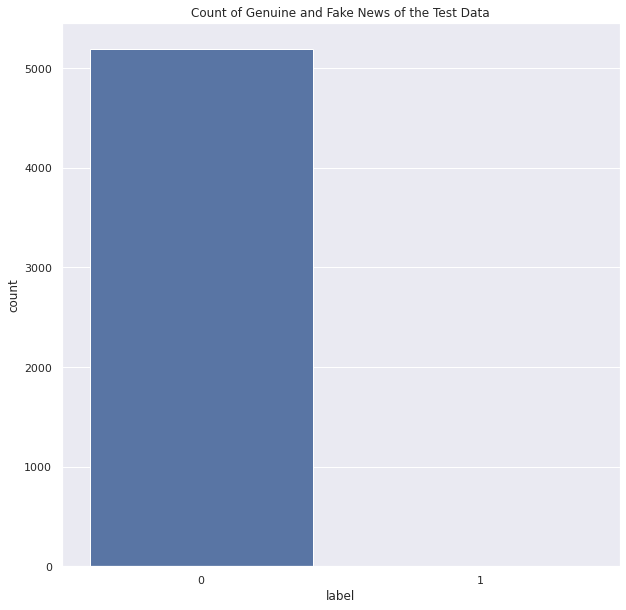

In [ ]:
sns.countplot(submit_lstm_predictions_df['label'])
plt.title("Count of Genuine and Fake News of the Test Data")
plt.show()

In [ ]:
submit_lstm_predictions_df.to_csv('submit.csv',index=False)

NameError: ignored